In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
import matplotlib.pyplot as plt
from PPDModel import get_ppd_model
from keras import models

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def get_dataset(name='mnist'):
    if name == 'mnist':
        dataset = tf.keras.datasets.mnist
    else:
        dataset = tf.keras.datasets.cifar10
    (x_train, y_train),(x_test, y_test) = dataset.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    if name == 'mnist':
        x_train = np.expand_dims(x_train, axis=3)  # PPDModel expects 4 dimensional image data
        x_test = np.expand_dims(x_test, axis=3)
    print('x_train shape', x_train.shape)
    print('y_train shape',y_train.shape)
    print('x_test shape',x_test.shape)
    print('y_test shape',y_test.shape)
    return (x_train, y_train, x_test, y_test)


def permute_pixels(images, seed):
    n_sample, img_r, img_c, n_channels = images.shape
    np.random.seed(seed)
    perm_idx = np.random.permutation(img_r*img_c)
    permuted_images = np.zeros_like(images)
    for idx in range(n_sample):
        for channel in range(n_channels):
            img = images[idx, :, :, channel].flatten()
            img = img[perm_idx]
            permuted_images[idx, :, :, channel] = img.reshape((img_r, img_c))
    return permuted_images

## TRAINING ON MNIST DATASET

x_train shape (60000, 28, 28, 1)
y_train shape (60000,)
x_test shape (10000, 28, 28, 1)
y_test shape (10000,)


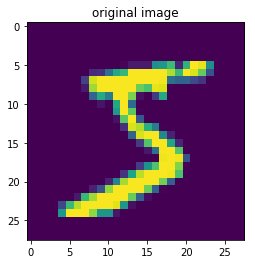

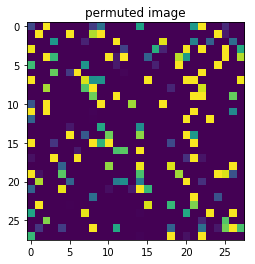

In [3]:
SECRET_SEED = 23
(x_train, y_train, x_test, y_test) = get_dataset('mnist')
plt.figure()
plt.imshow(x_train[0,:,:,0])
plt.title('original image')

x_train = permute_pixels(x_train, SECRET_SEED)
x_test = permute_pixels(x_test, SECRET_SEED)
plt.figure()
plt.imshow(x_train[0,:,:,0])
plt.title('permuted image')
plt.show()

In [4]:
model = get_ppd_model('mnist')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=15, verbose=1, batch_size=128, validation_data=(x_test, y_test))
model.save('models/mnist_trained_keras_model.hdf5')
print(model.evaluate(x_test, y_test))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 20s 330us/step - loss: 0.3004 - acc: 0.9097 - val_loss: 0.1613 - val_acc: 0.9481
Epoch 2/15
60000/60000 [==============================] - 18s 301us/step - loss: 0.0916 - acc: 0.9710 - val_loss: 0.1562 - val_acc: 0.9507
Epoch 3/15
60000/60000 [==============================] - 18s 298us/step - loss: 0.0482 - acc: 0.9845 - val_loss: 0.1624 - val_acc: 0.9528
Epoch 4/15
60000/60000 [==============================] - 22s 366us/step - loss: 0.0310 - acc: 0.9897 - val_loss: 0.1854 - val_acc: 0.9553
Epoch 5/15
60000/60000 [==============================] - 19s 320us/step - loss: 0.0326 - acc: 0.9892 - val_loss: 0.1803 - val_acc: 0.9557
Epoch 6/15
60000/60000 [==============================] - 20s 327us/step - loss: 0.0288 - acc: 0.9902 - val_loss: 0.2052 - val_acc: 0.9557
Epoch 7/15
60000/60000 [===========

## TRAINING ON CIFAR10 DATASET

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


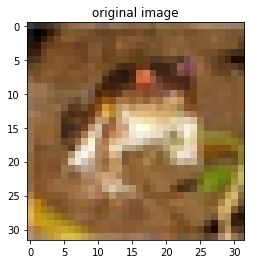

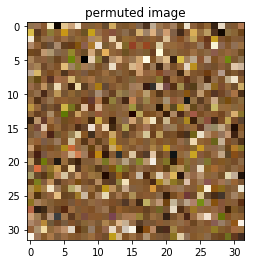

In [5]:
SECRET_SEED = 87
(x_train, y_train, x_test, y_test) = get_dataset('cifar10')
plt.figure()
plt.imshow(x_train[0])
plt.title('original image')

x_train = permute_pixels(x_train, SECRET_SEED)
x_test = permute_pixels(x_test, SECRET_SEED)
plt.figure()
plt.imshow(x_train[0])
plt.title('permuted image')
plt.show()

In [6]:
model = get_ppd_model('cifar10')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=15, verbose=1, batch_size=128, validation_data=(x_test, y_test))
model.save('models/cifar10_trained_keras_model.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 40s 799us/step - loss: 1.7677 - acc: 0.4031 - val_loss: 1.5887 - val_acc: 0.4462
Epoch 2/15
50000/50000 [==============================] - 43s 854us/step - loss: 1.2716 - acc: 0.5569 - val_loss: 1.6046 - val_acc: 0.4595
Epoch 3/15
50000/50000 [==============================] - 41s 829us/step - loss: 0.9334 - acc: 0.6774 - val_loss: 1.7412 - val_acc: 0.4472
Epoch 4/15
50000/50000 [==============================] - 39s 777us/step - loss: 0.6037 - acc: 0.7934 - val_loss: 2.0442 - val_acc: 0.4472
Epoch 5/15
50000/50000 [==============================] - 39s 781us/step - loss: 0.3632 - acc: 0.8761 - val_loss: 2.4070 - val_acc: 0.4326
Epoch 6/15
50000/50000 [==============================] - 39s 785us/step - loss: 0.2527 - acc: 0.9136 - val_loss: 2.8207 - val_acc: 0.4428
Epoch 7/15
50000/50000 [==============================] - 41s 822us/step - loss: 0.2028 - acc: 0.9303 - val_loss: 3.

In [ ]:
# load saved model with these lines
#http://everettsprojects.com/2018/01/30/mnist-adversarial-examples.html
#import keras
#from cleverhans.utils_keras import KerasModelWrapper
#from keras.models import load_model
#keras.backend.set_learning_phase(False)
#keras_model = load_model('models/cifar10_trained_keras_model.hdf5')
#wrap = KerasModelWrapper(keras_model)